In [1]:
#https://sep.readthedocs.io/en/v1.1.x/tutorial.html
import numpy as np
import sep
import glob
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LogNorm
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from matplotlib.patches import Ellipse, Circle
from astropy.coordinates import SkyCoord
from astropy import units as u
import os
from astropy.io import ascii
from astropy.table import Table, vstack
%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]
global sn_position
sn_position = SkyCoord(ra=211.6356531*u.degree, dec=-5.4517247*u.degree) # for sjt in ra/dec, change for your sn

In [2]:
#writes region files to outpath
#The coordinate convention in SEP is that (0, 0) corresponds to the center of the first element of the data array. 
#This agrees with the 0-based indexing in Python and C. However, note that this differs from the FITS convention where the 
#center of the first element is at coordinates (1, 1)
def writeregionfile(objects_new_table_cut, path_fits, outpath, color, sys = ''):
    objects_new_table_cut = objects_new_table_cut
    w = WCS(header)
    ra_pixel, dec_pixel = w.world_to_pixel(sn_position)
    filename = os.path.splitext(os.path.basename(path_fits))[0] + "_region.reg" # create/grab name
    completeName = outpath + filename
    out = open(completeName, 'w')
    #write the points
    out.write('# Region file format: DS9 version 4.0\nglobal color='+ color +' font="helvetica 10 normal" select=1 highlite=1 edit=1 move=1 delete=1 include=1 fixed=0 source\n')
    if sys == '': 
        sys = 'img'
        out.write('image\n')
        for i in range(len(objects_new_table_cut)):
            out.write("point(%.3f,%.3f) # point=boxcircle text={%i}\n" % (objects_new_table_cut['x'][i] + 1, objects_new_table_cut['y'][i] + 1, i))
        if len(objects_new_table_cut) == 0:
            print("ERROR: No stars detected. Increase sigma width.")
            sys.exit()
        out.write("circle(" + str(ra_pixel) + "," + str(dec_pixel) + "," + str(radius * 25.239777) +")\n")#25.239777 is 1 arcsec in physical
    out.close()
    print("writing region file:", filename)

In [3]:
def find_objects_cropped(cutout_filename, min_area):
    cutout_filename = cutout_filename
    min_area = min_area
    global data, header
    data, header = fits.getdata(cutout_filename, header=True)
    global w
    w = WCS(header)
    #if byte error use
    data = data.byteswap(inplace=True).newbyteorder()
    #find and display background
    bkg = sep.Background(data)
    bkg_image = bkg.back()
    #find and display background noise
    bkg_rms = bkg.rms()
    #remove background noise from  background
    sigma = 1.5
    global data_sub
    data_sub = data - bkg
    filter_kernel = np.array([[1, 2 , 1],
                             [2, 4, 2],
                             [1, 2, 1]])
    #objects = sep.extract(data_sub, sigma, err=bkg.globalrms, filter_kernel=filter_kernel, deblend_nthresh=16, deblend_cont=0.02, minarea=5, clean=True, clean_param=1.0) #ryans
    objects = sep.extract(data_sub, sigma, err=bkg.globalrms, filter_kernel=None, deblend_nthresh=80, deblend_cont=0.0000002, minarea=min_area, clean=False, clean_param=1.0) #mine
    #deblend_nthresh = defines a number of levels between the threshold and the max count of an object (in any "island" of point sources), then it constructs a tree of objects that branches if the number of counts in the branch are above a certain fraction of the total count in the island AND if there is another branch at that level with a similar fraction
    #deblend_cont = defines the fraction at which the tree is allowed to branch and separate objects (look on P.35 on chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/http://star-www.dur.ac.uk/~pdraper/extractor/Guide2source_extractor.pdf)
    #clean = if true, catalog is cleaned before being written to disk
    #clean_param = efficiency of cleaning, lower clean_param means brighter wings and more aggressive cleaning
    print("Found objects: " + str(len(objects)))
    return objects

In [4]:
#makes a cutout of size at sn position
def make_cutout_find_objects(path_fits, path_output, size_x, size_y, min_area):
    path_fits = path_fits
    path_output = path_output
    img=fits.open(path_fits)[0]
    hdu=img.header
    wcs_img = WCS(img.header)
    data=img.data
    try:
        cutout = Cutout2D(data, sn_position, (size_x, size_y), wcs=wcs_img)
    except ValueError:
        img=fits.open(path_fits)[1] #for some reason kirsty hst has to use this header
        hdu=img.header
        wcs_img = WCS(img.header)
        data=img.data
        cutout = Cutout2D(data, sn_position, (size_x, size_y), wcs=wcs_img)
    img.data = cutout.data
    img.header.update(cutout.wcs.to_header())
    global cutout_filename
    cutout_filename = os.path.splitext(os.path.basename(path_fits))[0] + "_cropped.fits"
    print("Writing cutout fits file : " + cutout_filename + " to " + path_output)
    img.writeto(path_output + cutout_filename, overwrite=True)
    return find_objects_cropped(path_output + cutout_filename, min_area) #returns object list

In [5]:
def cut_catalog(radius1, objects, path):
    path = path
    global radius
    radius = radius1
    #copy over objects list with new ra/dec type
    objects = objects
    new_dt = np.dtype(objects.dtype.descr + [('ra', '<f8'), ('dec', '<f8'), ('ind', 'int32')])
    objects_new = np.zeros(objects.shape, dtype=new_dt)
    objects_new['thresh'] = objects['thresh']
    objects_new['npix'] = objects['npix']
    objects_new['tnpix'] = objects['tnpix']
    objects_new['xmin'] = objects['xmin']
    objects_new['xmax'] = objects['xmax']
    objects_new['ymin'] = objects['ymin']
    objects_new['ymax'] = objects['ymax']
    objects_new['x'] = objects['x']
    objects_new['y'] = objects['y']
    objects_new['x2'] = objects['x2']
    objects_new['y2'] = objects['y2']
    objects_new['xy'] = objects['xy']
    objects_new['errx2'] = objects['errx2']
    objects_new['erry2'] = objects['erry2']
    objects_new['errxy'] = objects['errxy']
    objects_new['a'] = objects['a']
    objects_new['b'] = objects['b']
    objects_new['theta'] = objects['theta']
    objects_new['cxx'] = objects['cxx']
    objects_new['cyy'] = objects['cyy']
    objects_new['cxy'] = objects['cxy']
    objects_new['cflux'] = objects['cflux']
    objects_new['flux'] = objects['flux']
    objects_new['cpeak'] = objects['cpeak']
    objects_new['peak'] = objects['peak']
    objects_new['xcpeak'] = objects['xcpeak']
    objects_new['ycpeak'] = objects['ycpeak']
    objects_new['xpeak'] = objects['xpeak']
    objects_new['ypeak'] = objects['ypeak']
    objects_new['flag'] = objects['flag']

    for i in range(len(objects)):
        sky = w.pixel_to_world(objects['x'][i], objects['y'][i]) #convert ra/dec and add it
        objects_new['ra'][i], objects_new['dec'][i] = sky.ra.degree, sky.dec.degree

    objects_new_table = Table(objects_new)

    search_radius = radius * u.arcsec
    #find objects in radius
    radec = SkyCoord(ra=objects_new_table['ra']*u.degree, dec=objects_new_table['dec']*u.degree)
    d2d = sn_position.separation(radec)
    index = d2d < search_radius

    
    objects_new_table_cut = objects_new_table[index]
    #write the table
    ascii.write(objects_new_table_cut, path+cutout_filename+'.dat', overwrite=True)  
    return objects_new_table_cut

In [6]:
def make_plot (objects, path, filename):
    fig, ax = plt.subplots()
    w = WCS(header)
    ra_pixel, dec_pixel = w.world_to_pixel(sn_position)
    # plot an ellipse for each object
    for i in range(len(objects)):
        e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                    width=6*objects['a'][i],
                    height=6*objects['b'][i],
                    angle=objects['theta'][i] * 180. / np.pi)
        ax.annotate(str(i), xy=(objects['x'][i], objects['y'][i]+3), fontsize=10)
        e.set_facecolor('none')
        e.set_edgecolor('red')
        ax.add_artist(e)
    plt.figure(figsize=(12, 10))

    sn_plot = Circle(xy=(ra_pixel, dec_pixel), radius = 3 * 25.239777 , angle = 360)#25.239777 is 1 arcsec in physical
    sn_plot.set_facecolor('none')
    sn_plot.set_edgecolor('green')
    ax.add_artist(sn_plot)
    ax.set_title(cutout_filename)
    m, s = np.mean(data_sub), np.nanstd(data_sub)
    m = np.nanpercentile(data_sub, 50)
    im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
                   vmin=m-s, vmax=m+s, origin='lower')
    fig.savefig(path+filename+"_plot.png", dpi = 300, format = 'png')

In [7]:
##testing one single fits file IGNORE THIS!!!!
# path_fits = r"C:\Users\domdo\Lamat\Foley\drizzle img\pre_explosion_F814W\wfpc2.f814w.ref_0001.drz_pre_explosion_charlies_code.fits"
# path_output = "/Users/domdo/Lamat/Foley/drizzle img/pre_explosion_F814W/cropped/"
# path_region = "/Users/domdo/Lamat/Foley/photometry/drizzle_regions/"
# size_x = 500
# size_y = 500
# objects = make_cutout_find_objects(path_fits, path_output, size_x, size_y)
# objects_table_cut = cut_catalog(3, objects)
# writeregionfile(objects_table_cut, path_region, "red")
# make_plot(objects_table_cut)
# objects_table_cut
# ##testing one single fits file IGNORE THIS!!!!

Finding objects for wfc3.f350lp.ref_0001.drz.fits...
Writing cutout fits file : wfc3.f350lp.ref_0001.drz_cropped.fits to C:/Users/ronno/Desktop/Transients/HST project/jupyter_codes/2023cj/reference images/F350LP/cropped/
Found objects: 505
writing region file: wfc3.f350lp.ref_0001.drz_region.reg


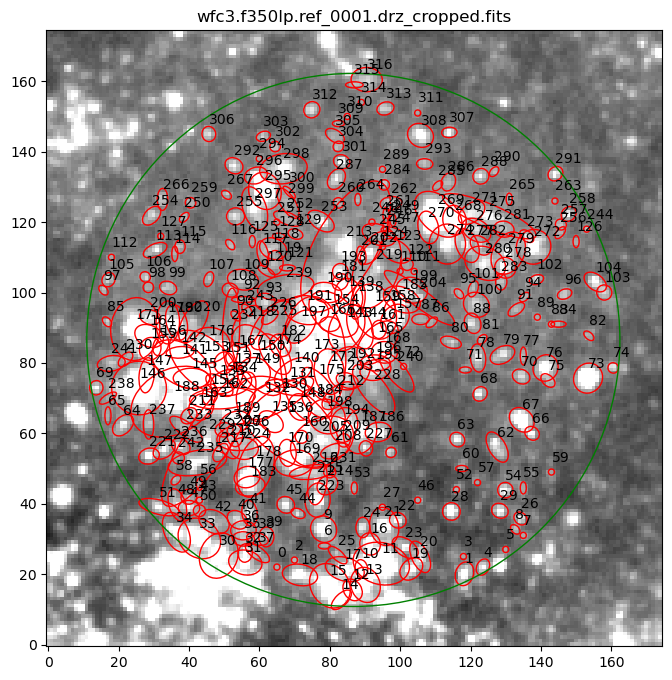

<Figure size 1200x1000 with 0 Axes>

In [8]:
path = "C:/Users/ronno/Desktop/Transients/HST project/jupyter_codes/2023cj/reference images/F350LP/"
#path should contain fits file ONLY!!!
size_x = 175 #change size of cutout
size_y = 175 #change size of cutout
radius = 3 #change search radius
min_area = 1.0 #change min area detection

dir_list = glob.glob(path)
filenames = [os.path.basename(x) for x in glob.glob(path+"*.fits")]
os.mkdir(path+"cropped")
path_output = path + 'cropped/'
os.mkdir(path+"regions")
path_region = path + 'regions/'
count = 0
#for each file in path
for count, filename in enumerate(filenames):
    print("Finding objects for " + filename + "...")
    objects = make_cutout_find_objects(path+filename, path_output, size_x, size_y, min_area)
    objects_table_cut = cut_catalog(radius, objects, path)
    writeregionfile(objects_table_cut, path+filename, path_region, "red")
    make_plot(objects_table_cut, path, filename)
    objects_table_cut

In [9]:
#automate: be able to change the crop, run extract on cutout, search catalog around pixel coordinate of radius (parameter), plot cutout,  plot ellipse at ra/dec, and ellipse of radius, catalog returns flag